<center>

# **📘 Patent Classification - Task 3**

## *State of the Art (SOA) Comparison*

</center>

In this notebook, we explore the performance of **RoBERTa** trained on different portions of the training size and analyze its performance for patent classification compared to the **State of the Art** models.

This section was trained on Google Collab T4 GPU.

# **Outline**
---


1. [🚀 3.A. Full Dataset Training](#part1)
2. [📈 3.B. Learning Curve](#part1)  
3. [🔍 3.B.2 Inside RoBERTa - Understanding predictions](#part1)  
3. [🆚 3.C. Technique Comparison](#part1)
4. [👀 3.D. Mehtodology Analysis](#part1)  

In [1]:
COLLAB = False
if COLLAB:
    !pip install -U datasets transformers evaluate transformers-interpret

In [2]:
# Standard Library
import json
import random
import warnings
from pathlib import Path

# Third-Party Libraries
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from datasets import load_dataset, load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
)
from transformers_interpret import SequenceClassificationExplainer

# Local Modules
from utils import (
    Metrics,
    create_args_training,
    train_and_predict,
)

# Suppress warnings and set Seaborn style
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
sns.set_palette("Spectral")

if COLLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    OUTPUT_DIR = "/content/drive/MyDrive/NLP_trial_final_project/abstracts"
else:
    OUTPUT_DIR = "./results"


In [3]:
if Path(f"{OUTPUT_DIR}/dataset_patents_abstracts").exists():
  dataset = load_from_disk(f"{OUTPUT_DIR}/dataset_patents_abstracts")
else:
  dataset = load_dataset("ccdv/patent-classification", "abstract")
  dataset.save_to_disk(f"{OUTPUT_DIR}/dataset_patents_abstracts")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

# **3.A. Full Dataset Training**
---
Incrementally train your model with varying percentages of the full dataset (1%, 10%, 25%, 50%, 75%, and 100%). Record the results.

In [5]:
n_classes = len(set(dataset['train']['label']))
n_classes

9

In [6]:
model_ckpt   = "FacebookAI/roberta-base"
num_labels   = n_classes
max_length   = 256
batch_size   = 64
seed         = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(seed)

In [7]:
if Path(f"{OUTPUT_DIR}/dataset_patents_abstracts_tokenized_{model_ckpt}").exists():
  dataset = load_from_disk(f"{OUTPUT_DIR}/dataset_patents_abstracts_tokenized_{model_ckpt}")
  dataset.set_format("torch")
else:
  tok = AutoTokenizer.from_pretrained(model_ckpt)
  def tokenize(batch):
      return tok(batch["text"], padding="max_length", truncation=True, max_length=max_length)

  dataset = dataset.map(tokenize, batched=True, remove_columns=["text"])
  dataset = dataset.rename_column("label", "labels")
  dataset.set_format("torch")
  dataset.save_to_disk(f"{OUTPUT_DIR}/dataset_patents_abstracts_tokenized_{model_ckpt}")

In [ ]:
results = Metrics()
predictions = {}
for train_proportion in [0.01, 0.1, 0.25, 0.5, 0.75, 1]:
    print(f"Training with {train_proportion * 100}% of the training data")
    args = create_args_training(n_epochs=20,
                                output_dir= f"{OUTPUT_DIR}/{model_ckpt}/results_{train_proportion*100}"
                                )
    results, y_pred, y_true = train_and_predict(dataset, model_ckpt, args, results, train_proportion)
    predictions[train_proportion] = {
        "y_pred": y_pred,
        "y_true": y_true
    }
    with open( f"{OUTPUT_DIR}/{model_ckpt}/predictions.json", "w") as f:
        json.dump(predictions, f)

# **3.B. Learning Curve**
---
Plot a learning curve based on the training data percentages.

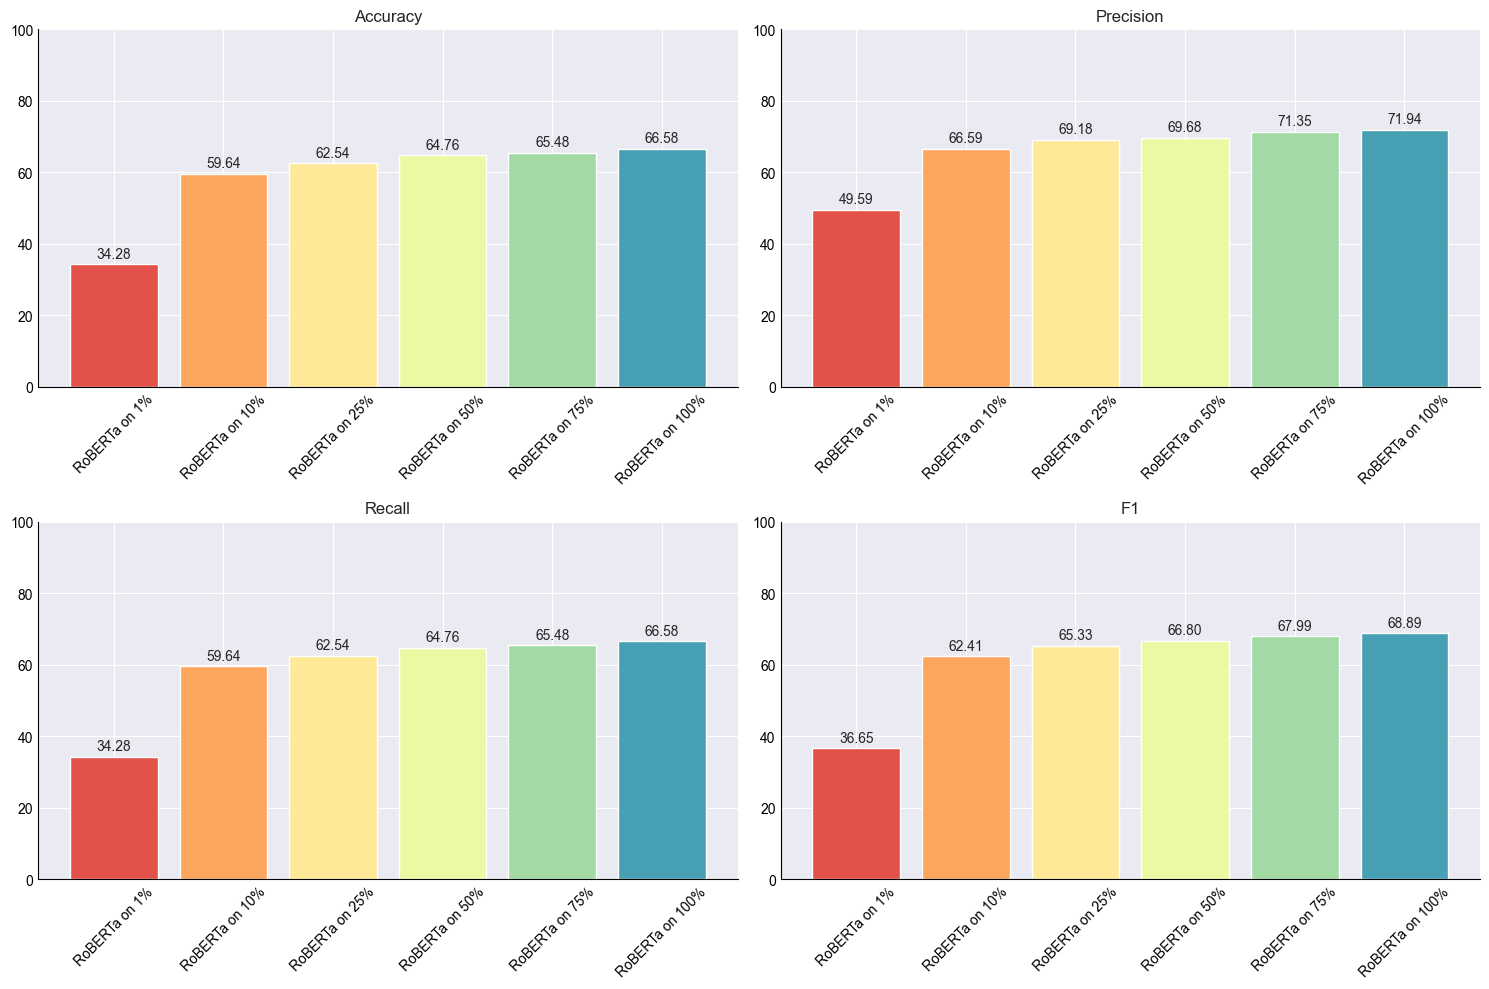

In [ ]:
results.plot(save_plot_path=f"{OUTPUT_DIR}/{model_ckpt}/results_test.png")

The results above show the performance of the model on the `TEST SET` using different percentages of the trainig set.
It is interesting to notice the diminishig returns of the training size to the performance: with the first 50% of the data the model reaches almost 60% of F1-Weighted score, while the remaining 50% only allows the model to improve its performance by 2pp.

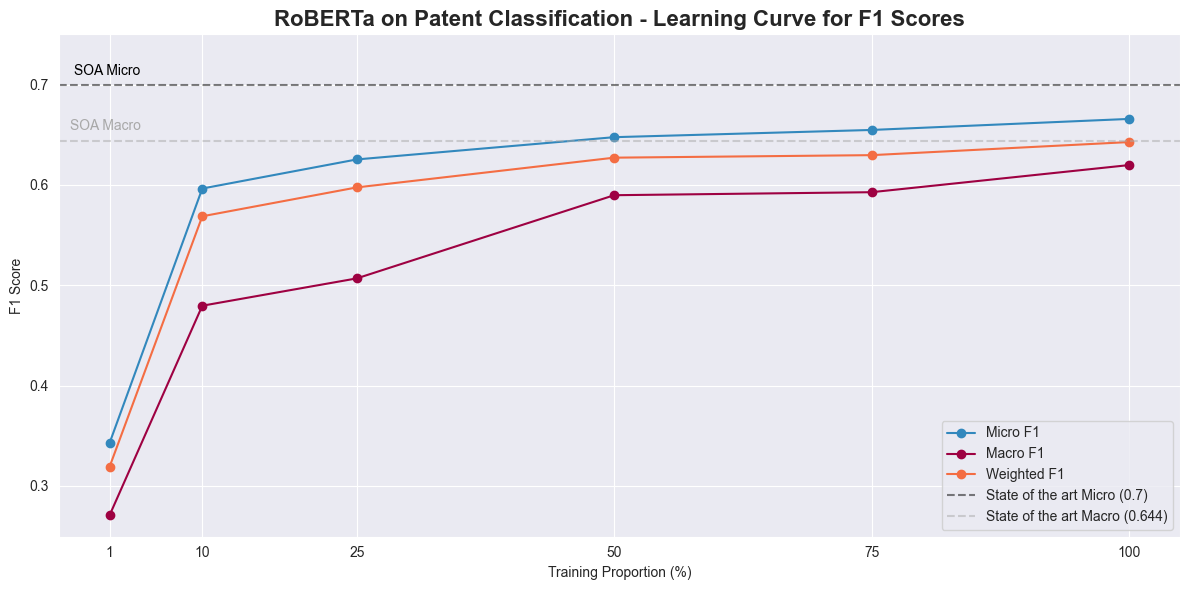

In [9]:
json_path = "results/FacebookAI/roberta-base/predictions.json"
predictions = json.load(open(json_path, "r"))
micro_f1_results = []
macro_f1_results = []
weighted_f1_results = []
for train_proportion, pred in predictions.items():
    prop = str(int(float(train_proportion)* 100))
    y_pred = pred["y_pred"]
    y_true = pred["y_true"]
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    micro_f1_results.append(micro_f1)
    macro_f1_results.append(macro_f1)
    weighted_f1_results.append(weighted_f1)

#make a plot with title learning curve

#use 
plt.figure(figsize=(12, 6))
plt.plot([1, 10, 25, 50, 75, 100], micro_f1_results, label='Micro F1', marker='o', color="#3288bd")
plt.plot([1, 10, 25, 50, 75, 100], macro_f1_results, label='Macro F1', marker='o', color="#9e0142")
plt.plot([1, 10, 25, 50, 75, 100], weighted_f1_results, label='Weighted F1', marker='o', color="#f46d43")
#add hline at 0.66
plt.axhline(y=0.7, color='black', linestyle='--', alpha=0.5, label='State of the art Micro (0.7)')
plt.axhline(y=0.644, color='darkgrey', linestyle='--', alpha=0.5, label='State of the art Macro (0.644)')
#add am x
plt.title('RoBERTa on Patent Classification - Learning Curve for F1 Scores', fontsize=16, fontweight='bold')
plt.xlabel('Training Proportion (%)')
plt.ylabel('F1 Score')
#add y tick at 0.666 with tick SOA Micro and 0.618 with tick SOA Macro
plt.text(4, 0.71, 'SOA Micro', fontsize=10, color='black', ha='right')
plt.text(4, 0.655, 'SOA Macro', fontsize=10, color='darkgrey', ha='right')

plt.ylim(None, 0.75)
plt.xticks([1, 10, 25, 50, 75, 100])
plt.grid(False)
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/{model_ckpt}/learning_curve_f1_scores.png")
plt.show()


This image plots the different F1 scores obtained on the `TEST SET` using the full training set to train the model, achiveing results close to the State of the Art (SOA).

# **3.B.2 Inside RoBERTa - Understanding predictions**
---
Understanding model decisions and insights.

In [10]:
original_dataset = load_from_disk(f"{OUTPUT_DIR}/dataset_patents_abstracts")

In [11]:
BEST_MODEL = f"{OUTPUT_DIR}/{model_ckpt}/results_100/checkpoint-1176"
model = AutoModelForSequenceClassification.from_pretrained(BEST_MODEL)
model.to(torch.float32) # Ensure model is in float32 for compatibility
model.eval()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
trainer = Trainer(model=model, tokenizer=tokenizer)

predictions = trainer.predict(dataset["test"])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

In [12]:
correct_predictions = [(text, true_label, pred_label)
                    for text, true_label, pred_label in zip(original_dataset['test']['text'], y_true, y_pred)
                    if true_label == pred_label
                    ][:5]

wrong_predictions = [(text, true_label, pred_label)
                    for text, true_label, pred_label in zip(original_dataset['test']['text'], y_true, y_pred)
                    if true_label != pred_label
                    ][:5]


In [13]:
# Load examples
BEST_MODEL = f"{OUTPUT_DIR}/{model_ckpt}/results_100/checkpoint-1176"
model = AutoModelForSequenceClassification.from_pretrained(BEST_MODEL)
model.eval()
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# Create explainer
explainer = SequenceClassificationExplainer(model, tokenizer)

In [14]:
print("CORRECT PREDICTIONS ===================================")
for text, true_label, pred_label in correct_predictions:
# text, true_label, pred_label = examples[0][0], examples[0][1], examples[0][2]
    word_attributions = explainer(text)

    CLASS_NAMES = {
        0: "Human Needs", 1: "Operations & Transport", 2: "Chemistry & Metallurgy",
        3: "Textiles & Paper", 4: "Construction", 5: "Mechanical & Thermal Engineering",
        6: "Physics", 7: "Electricity", 8: "Cross-Tech Tagging"
    }

    explainer.visualize(true_class=CLASS_NAMES[true_label])

CORRECT PREDICTIONS ===================================


For the correct predictions, it is interesting to notice the following:
1. The confidence level is above 0.7 on average
2. The model is able to distinguish the most relevant postivice tokens of each abstract: `building`, `'device`, `head assembly`, `polymer`, `reading information`, `producing`, `pressure`, among others.


In [15]:
print("INCORRECT PREDICTIONS ===================================")
for text, true_label, pred_label in wrong_predictions:
# text, true_label, pred_label = examples[0][0], examples[0][1], examples[0][2]
    word_attributions = explainer(text)

    CLASS_NAMES = {
        0: "Human Needs", 1: "Operations & Transport", 2: "Chemistry & Metallurgy",
        3: "Textiles & Paper", 4: "Construction", 5: "Mechanical & Thermal Engineering",
        6: "Physics", 7: "Electricity", 8: "Cross-Tech Tagging"
    }

    explainer.visualize(true_class=CLASS_NAMES[true_label])

INCORRECT PREDICTIONS ===================================


In contrast to the correct predictions, in this case we can see:
1. Way lower scores (reaching 0.35) and the average around 0.59. 
2. There are some really miselading abstracts, also for the human eye, such as the second example, where `polymer` and `chemical` have a high positive score associated with Chemestry & Metallurgy while the true class was Operations and Transport.
3. The modell still has some wrong attention, as it can be seen in the 4th case, where `well` is giving a high score to classify that instance as Construction when it is from Cross-Tech Tagging.

# **3.C. Technique Comparison**
---

For this part, we analyzed caerfully the different options tested in Part 2 (Task 2). After reviewing each of the techniques applied, we conclude the following:

- `Generate data augmentation` will not improve the model considerably. First, we mentioned above the decreasing marginal returns on the data to model performance. At this point, to have a marginal impact on the performance we would need to generate at least another extra 50% by shuffling the sentence order, with the risk of introducing more degradation that real variation to it.

- `Zero shot learning` will not apply, as we count with loads of labeled instances (25K).

- For `Data Generation with LLMs`, as we already see a decreasing marginal returns of training data on model perfomance (the second half of the training set improves only 2pp performance in F1-Weighted), our intuition says we would need again to generate at least 12.5K more instances to have a marginal impact on the model, in which we don't have the corresponding API credits to do so.

- `SetFit` is particularlly usefull when few labeled instances are available (few shot learning) to fine trune sentence transformers for text classification. Again, this wouldn't make sense for 25K training instances.

For all this reasons, we concluded that the best approach we could take was to rely on the best performing model we have so far.

# **3.D. Methodology Analysis**
---

To evaluate different strategies for patent classification, we explored a variety of learning methodologies (Few/Zero Shot learning, Data Augmentation, Incremental FIne Tuning) using both BERT-based models and large language models (LLMs). Below, we resume the key findings and limitations observed:

### **1. Full Text vs. Abstracts**

We initially worked with the full patent texts, which can exceed 80K tokens. Although this offers rich context and detailed technical language, such length exceeds the input limits of transformer-based models (e.g., BERT, RoBERTa), making it computationally infeasible under resource-constrained settings.

To address this, we shifted to using only patent abstracts, which are far shorter and more uniform across samples. This change enabled us to efficiently train models while sacrificing some linguistic diversity and fine-grained class cues. Despite this trade-off, the performance achieved using abstracts—especially with a general-purpose model like RoBERTa (not specialized for patent language) remains competitive when compared to SOA systems, which often rely on full texts and larger datasets.

### **2. Few-Shot Learning and LLM-Based Zero-Shot**

We evaluated Few-Shot learning by training BERT with a small subset (32 examples), and explored Zero-Shot Learning using LLM-generated labels and sentence shuffling for augmentation. However, these approaches showed limited effectiveness, primarily due to the specialized and obscure vocabulary of patent language. Most pretrained models (e.g., BERT, RoBERTa, LLMs) are trained on general domains, making it difficult for them to understand domain-specific terminology and structure—especially in such small-data settings.

Moreover, patent texts are intentionally written in **complex and technical styles**, often using uncommon or obfuscated terms to describe innovations. This makes it difficult for LLMs to generate useful augmentations or reliable zero-shot predictions without domain adaptation.

### **3. Incremental Training with RoBERTa**

To assess data efficiency, we incrementally fine-tuned **RoBERTa** using 1%, 10%, 25%, 50%, 75%, and 100% of the training set. We observed a clear upward trend in performance as more data was added, confirming that model accuracy scales with training volume. This gradual approach highlights the benefit of domain adaptation—even for general-purpose models—and reinforces that contextualized embeddings outperform static methods when sufficient data is available.

### **4. Class Overlap and Ambiguity**

We work with 9 broad patent categories, some of which (Electricity, Physics, Cross-Tech) show significant vocabulary overlap. This makes classification challenging, especially when using abstracts alone, which may lack the detail necessary to distinguish fine-grained differences. More granular subcategories or hierarchical classification could improve performance by narrowing class boundaries.

### **Conclusion**

Overall, our experiments reveal the following:

* **Contextual models (e.g., RoBERTa)** significantly outperform static approaches when enough data is available.
* **Abstracts offer a good trade-off** between informativeness and computational efficiency, though they limit fine-grained discrimination.
* **Few-shot and zero-shot methods struggle** due to vocabulary mismatch and domain complexity.
* Future work should explore **domain-specific models (e.g., PatentBERT)** and **hierarchical classification schemes** to further improve results.